In [10]:
%pip install pycaret
%pip install nltk
%pip install scikit-learn


^C
Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
import nltk
from textblob import TextBlob
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
plt.rc('figure',figsize=(20,11))

In [3]:
csv_file_path = os.path.join('..', 'data', 'data.csv')
csv_file_path

'..\\data\\data.csv'

In [5]:
import pandas as pd
df = pd.read_csv(csv_file_path)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
df.shape

(20491, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [10]:
df.describe(include='all')

,Review,Rating
count,20491,20491.000000
unique,20491,NaN
top,nice hotel expensive parking got good deal sta...,NaN
freq,1,NaN
mean,NaN,3.952223
std,NaN,1.233030
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,4.000000
75%,NaN,5.000000


In [11]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [12]:
data = df.copy(deep=True)
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [46]:
## clean data
from string import punctuation
from nltk import pos_tag
lemmatizer = WordNetLemmatizer()
ps=PorterStemmer()
stopwords = set(STOPWORDS)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun
    
def clean_data(text):
    translator = str.maketrans('', '', punctuation)
    text_punction_rm = text.translate(translator)
    text_stop_rm = [word.lower() for word in text_punction_rm.split(" ") if word not in stopwords and word.isalpha() ]
    pos_tags = pos_tag(text_stop_rm)
    cleaned_data = [lemmatizer.lemmatize(word,pos=get_wordnet_pos(pos_tag)) for word,pos_tag in pos_tags]
    return " ".join(cleaned_data)

In [57]:
data['clened_review'] = data['Review'].apply(clean_data)
data['word_count'] = data['clened_review'].apply(lambda x: len(x.split(" ")))
data['word_char_count'] = data['clened_review'].apply(lambda x: len(x))
data['avg_word_count'] = data['clened_review'].apply(lambda x: (len(x)-len(x.split(" "))+1)/len(x.split(" ")))

In [58]:
data.loc[0]

Review             nice hotel expensive parking got good deal sta...
Rating                                                             4
clened_review      nice hotel expensive parking get good deal sta...
word_count                                                        79
word_char_count                                                  513
avg_word_count                                              5.506329
Name: 0, dtype: object

In [64]:
# add other features
vader_sentiment = SentimentIntensityAnalyzer()
def get_sentiment_vader(text):
    sentiment_dct = vader_sentiment.polarity_scores(text)
    if sentiment_dct['compound']>=0.05:
        return "Positive"
    elif sentiment_dct['compound']<=-0.05:
        return "Negative"
    else:
        return "Neutral"

In [70]:
def get_sentiment_textblob(text):
    sentiment_score = TextBlob(text).sentiment.polarity
    if sentiment_score<0:
        return "Negative"
    elif sentiment_score>=0 and sentiment_score<=0.2:
        return "Neutral"
    else:
        return "Positive"

In [65]:
# add sentiment from rating
def get_sentiment_from_rating(rating):
    if rating in [4,5]:
        return "Positive"
    elif rating in [1,2]:
        return "Negative"
    elif rating==3:
        return "Neutral"
    else:
        return "NA"

In [71]:
%%time
data['sentiment_vader'] = data['clened_review'].apply(get_sentiment_vader)
data['sentiment_textblob'] = data['clened_review'].apply(get_sentiment_textblob)
data['sentiment_rating'] = data['Rating'].apply(get_sentiment_from_rating)

Wall time: 34.8 s


In [73]:
data.head()

,Review,Rating,clened_review,word_count,word_char_count,avg_word_count,sentiment_vader,sentiment_textblob,sentiment_rating
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...,79,513,5.506329,Positive,Neutral,Positive
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,226,1509,5.681416,Positive,Positive,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,195,1270,5.517949,Positive,Positive,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,83,532,5.421687,Positive,Positive,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...,178,1106,5.219101,Positive,Positive,Positive


In [75]:
# def get_final_sentiment(x,y,z):
#     if [x,y,z].unique()
data['sentiment_final'] = data[['sentiment_vader','sentiment_textblob','sentiment_rating']].mode(axis=1)[0]

In [88]:
data.iloc[20489,[3,4,5]].value_counts()

735.000000     1
5004.000000    1
5.809524       1
Name: 20489, dtype: int64

In [76]:
data[['sentiment_vader','sentiment_textblob','sentiment_rating']].mode(axis=1)

,0,1,2
0,Positive,NaN,NaN
1,Positive,NaN,NaN
2,Positive,NaN,NaN
3,Positive,NaN,NaN
4,Positive,NaN,NaN
...,...,...,...
20486,Positive,NaN,NaN
20487,Positive,NaN,NaN
20488,Positive,NaN,NaN
20489,Negative,Neutral,Positive


In [77]:
data

,Review,Rating,clened_review,word_count,word_char_count,avg_word_count,sentiment_vader,sentiment_textblob,sentiment_rating,sentiment_final
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...,79,513,5.506329,Positive,Neutral,Positive,Positive
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,226,1509,5.681416,Positive,Positive,Negative,Positive
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,195,1270,5.517949,Positive,Positive,Neutral,Positive
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,83,532,5.421687,Positive,Positive,Positive,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...,178,1106,5.219101,Positive,Positive,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret time stay charm ca nt beat ti...,104,653,5.288462,Positive,Positive,Positive,Positive
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...,38,288,6.605263,Positive,Positive,Positive,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff nt part...,61,403,5.622951,Positive,Positive,Negative,Positive
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruin vacation hotel open sept gues...,735,5004,5.809524,Positive,Neutral,Negative,Negative


### Explore the created Data

In [106]:

def create_wordcloud(word_list,custom_stop_words):
    wordcloud = WordCloud(width=400, height=400, background_color='white',stopwords=custom_stop_words,min_font_size=5).generate(word_list)
    plt.figure(figsize=(15,5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

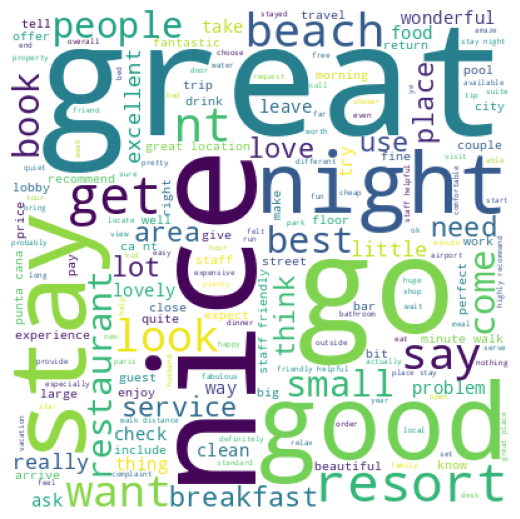

In [107]:
# addig custom stop words
custom_stop_words = ["hotel","room","day","time"]
word_list = " ".join(data.loc[data['sentiment_final']=='Positive','clened_review'].tolist())
create_wordcloud(word_list=word_list,custom_stop_words=custom_stop_words)

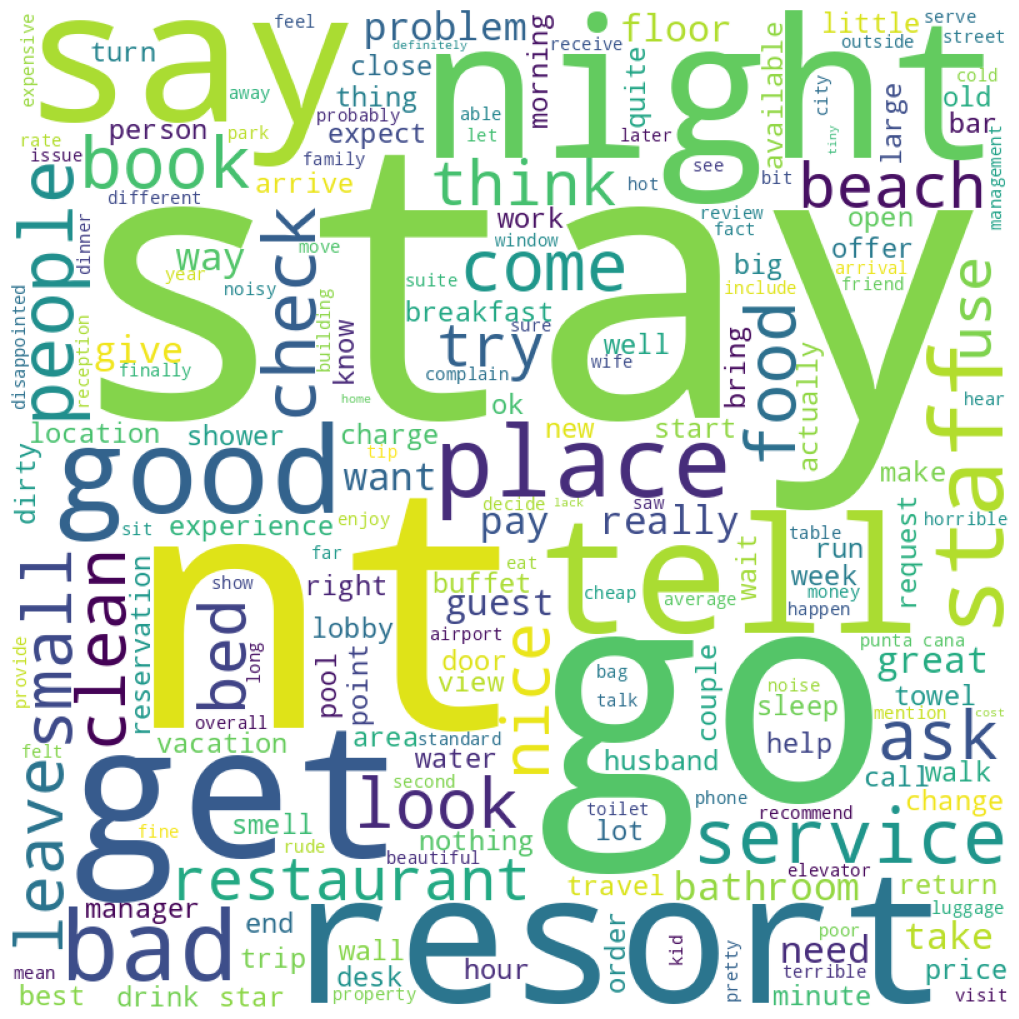

In [97]:
# addig custom stop words
custom_stop_words = ["hotel","room","day","time"]
word_list = " ".join(data.loc[data['sentiment_final']=='Negative','clened_review'].tolist())
create_wordcloud(word_list=word_list,custom_stop_words=custom_stop_words)

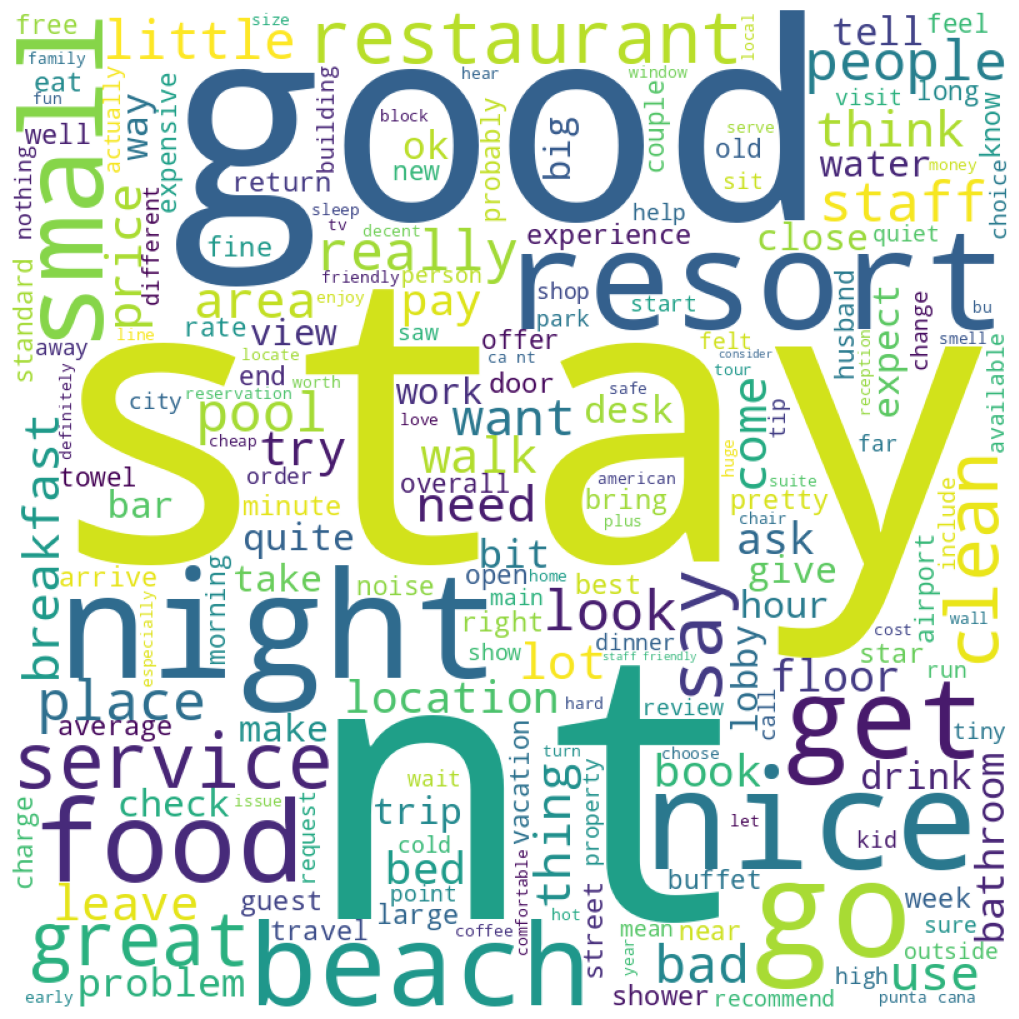

In [98]:
# addig custom stop words
custom_stop_words = ["hotel","room","day","time"]
word_list = " ".join(data.loc[data['sentiment_final']=='Neutral','clened_review'].tolist())
create_wordcloud(word_list=word_list,custom_stop_words=custom_stop_words)

### Build Model

In [114]:
final_model_data = data[['clened_review','sentiment_final']].copy()
final_model_path = os.path.join('..', 'data', 'final_model_data.csv')
final_model_data.to_csv(final_model_path,index=False) #backup file

In [111]:
### Read the data

In [115]:
# load the data
final_model_path = os.path.join('..', 'data', 'final_model_data.csv')
final_model_data = pd.read_csv(final_model_path)
final_model_data.head()

,clened_review,sentiment_final
0,nice hotel expensive parking get good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Positive
2,nice room experience hotel monaco seattle good...,Positive
3,unique great stay wonderful time hotel monaco ...,Positive
4,great stay great stay go seahawk game awesome ...,Positive


In [131]:
final_model_data['sentiment_final'].value_counts(dropna=False,normalize=True)

Positive    0.821434
Negative    0.130448
Neutral     0.048119
Name: sentiment_final, dtype: float64

In [118]:
#split data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_model_data['clened_review'],final_model_data['sentiment_final'],random_state=42,test_size=0.3)
print(f"X_train : {X_train.shape} | X_test : {X_test.shape} | y_train : {y_train.shape} | y_test : {y_test.shape}")


X_train : (14343,) | X_test : (6148,) | y_train : (14343,) | y_test : (6148,)


In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"X_train_tfidf : {X_train_tfidf.shape} | X_test_tfdf : {X_test_tfidf.shape}")


X_train_tfidf : (14343, 55819) | X_test_tfdf : (6148, 55819)


In [134]:
# get the models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [138]:
model_dt = DecisionTreeClassifier(random_state=102).fit(X_train_tfidf,y_train)
y_pred_dt = model_dt.predict(X_test_tfidf)
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))

[[ 384   70  334]
 [  71   37  193]
 [ 254  155 4650]]
              precision    recall  f1-score   support

    Negative       0.54      0.49      0.51       788
     Neutral       0.14      0.12      0.13       301
    Positive       0.90      0.92      0.91      5059

    accuracy                           0.82      6148
   macro avg       0.53      0.51      0.52      6148
weighted avg       0.82      0.82      0.82      6148



In [142]:
from sklearn.ensemble import RandomForestClassifier
model_rf=RandomForestClassifier(random_state = 102).fit(X_train_tfidf,y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

[[ 117    0  671]
 [   4    0  297]
 [   1    0 5058]]
              precision    recall  f1-score   support

    Negative       0.96      0.15      0.26       788
     Neutral       0.00      0.00      0.00       301
    Positive       0.84      1.00      0.91      5059

    accuracy                           0.84      6148
   macro avg       0.60      0.38      0.39      6148
weighted avg       0.81      0.84      0.78      6148



d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [144]:
### Model optimization
from sklearn.model_selection import RandomizedSearchCV,cross_val_score

In [155]:
random_grid_search = {'criterion':['entropy','gini'],
                      'max_depth':range(2,16,3),
                      'max_features':['auto','sqrt'],
                      'min_samples_leaf':[4,6,8],
                      'min_samples_split':[5,7,10],
                      'n_estimators':[5,10,20,30]
                      }
rf_clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator=rf_clf, param_distributions=random_grid_search, n_iter=10, cv=4, verbose=1, random_state=101,
                           return_train_score=True)
model.fit(X_train_tfidf,y_train)
model.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_leaf=8,
                       min_samples_split=10, n_estimators=20)

In [162]:
y_pred_rf_tuned = model.best_estimator_.predict(X_test_tfidf)
print(confusion_matrix(y_test,y_pred_rf_tuned))
print(classification_report(y_test,y_pred_rf_tuned))

[[   0    0  788]
 [   0    0  301]
 [   0    0 5059]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       788
     Neutral       0.00      0.00      0.00       301
    Positive       0.82      1.00      0.90      5059

    accuracy                           0.82      6148
   macro avg       0.27      0.33      0.30      6148
weighted avg       0.68      0.82      0.74      6148



d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\Data Science\Machine Learning\Sentiment Analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [161]:
model.cv_results_

{'mean_fit_time': array([0.73027432, 0.30721956, 0.61520034, 0.60554004, 0.7126801 ,
        0.23438996, 0.16538203, 0.68517178, 0.54382306, 0.43894446]),
 'std_fit_time': array([0.04407764, 0.00654568, 0.00818884, 0.00791373, 0.01702872,
        0.01829648, 0.00278051, 0.00347457, 0.00256815, 0.00437355]),
 'mean_score_time': array([0.03755563, 0.03526789, 0.04018164, 0.05857497, 0.03713095,
        0.0472976 , 0.02513617, 0.03741348, 0.03652704, 0.0341484 ]),
 'std_score_time': array([0.0024459 , 0.00178963, 0.00413063, 0.02899985, 0.00149238,
        0.00190945, 0.00073597, 0.00117816, 0.00184746, 0.00086688]),
 'param_n_estimators': masked_array(data=[20, 20, 20, 20, 20, 30, 10, 20, 20, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 5, 7, 5, 10, 7, 7, 7, 7, 7],
              mask=[False, False, False, False, Fals